<a href="https://colab.research.google.com/github/Uniholder/DeepLearningSchool/blob/main/2_semester/4_Language_modelling/%5Bhomework%5Dlanguage_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [1]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [2]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
tags = [tag for (word, tag) in brown_tagged_words]
tags[:10]

['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP']

In [ ]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [ ]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

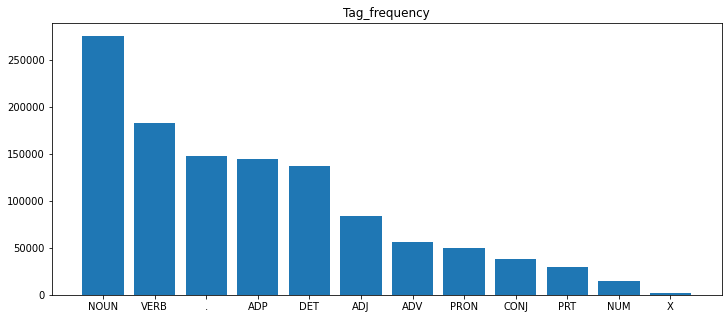

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

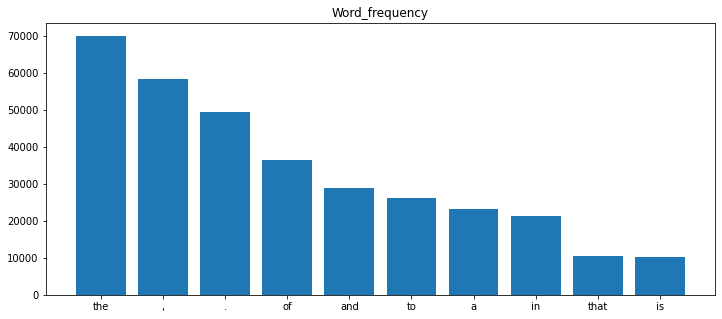

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [ ]:
word_num['cat']

23

Ответ: 23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [ ]:
most_freq_tag = tag_num.index[0]  # noun
brown_tagged_words_df = pd.DataFrame(brown_tagged_words, columns=['word', 'tag'])
nouns = brown_tagged_words_df[brown_tagged_words_df.tag == most_freq_tag]
nouns.word.value_counts()

time                1597
man                 1203
af                   995
years                949
way                  899
                    ... 
exboyfriend            1
near-equivalents       1
sharecrop              1
porcupines             1
rafer                  1
Name: word, Length: 30246, dtype: int64

Ответ: time (noun)

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype=object)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, random_state=0, test_size=0.1)

In [ ]:
len(train_sents)

947

In [ ]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамического программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:
    def __init__(self):
        pass
        

    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train)
        """
        tags = [tag for sent in train_tokens_tags_list for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        A = pd.DataFrame({f'{tag}': [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({f'{tag}': [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        # переходим к вероятностям
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis='columns'), axis='index')
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B.divide(B.sum(axis='index'), axis='columns')
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            current_sent = test_tokens_list[i_sent].copy() # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = 'time'  # хардкод для текущей задачи
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    s = self.tags[i_s]
                    # формула (1)
                    q[t + 1][i_s] = np.max(
                        q[t, :] * 
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s]
                    )
                    
                    # argmax формула(1)
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (
                        q[t, :] * 
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s]
                    ).reset_index()[s].idxmax() # индекс
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [ ]:
model = HiddenMarkovModel()
model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

In [ ]:
lowered_sents = []
for sent in sents:
    lowered_sents.append([word.lower() for word in sent])
lowered_sents

[['he', 'can', 'stay'],
 ['a', 'cat', 'and', 'a', 'dog'],
 ['i', 'have', 'a', 'television'],
 ['my', 'favourite', 'character']]

In [ ]:
model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

In [ ]:
model.predict(lowered_sents)

OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

Обучение на всех категориях

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents, dtype=object)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, random_state=0, test_size=0.1)

In [ ]:
len(train_sents), len(test_sents)

(51606, 5734)

In [ ]:
%%time
model = HiddenMarkovModel()
model.fit(train_sents)

CPU times: user 8min 43s, sys: 1min 7s, total: 9min 50s
Wall time: 8min 53s


In [ ]:
sents

[['He', 'can', 'stay'],
 ['a', 'cat', 'and', 'a', 'dog'],
 ['I', 'have', 'a', 'television'],
 ['My', 'favourite', 'character']]

In [ ]:
model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

In [ ]:
model.predict(lowered_sents)

OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?

Ответ:

VERB

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

Ответ:

NOUN

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [ ]:
from tqdm.notebook import tqdm

def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in tqdm(sents):
        tags = [tag for (word, tag) in sent]
        words = [word for (word, tag) in sent]

        pred = model.predict([words])

        true_pred += (pred[0] == tags).sum()
        num_pred += len(pred[0])
        
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [ ]:
%%time
accuracy_score(model, test_sents)

  0%|          | 0/106 [00:00<?, ?it/s]

Accuracy: 88.82847256549678 %
CPU times: user 45.9 s, sys: 491 ms, total: 46.4 s
Wall time: 46.1 s


На всей выборке

In [ ]:
%%time
accuracy_score(model, test_sents)

  0%|          | 0/5734 [00:00<?, ?it/s]

Accuracy: 96.26295331104619 %
CPU times: user 52min 42s, sys: 1min 35s, total: 54min 18s
Wall time: 52min 48s


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

Ответ:

88.8 %

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger('NOUN')

In [ ]:
default_tagger.evaluate(test_sents)

0.20217498764211567

Ответ:

20.2%

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
test_tagged_sents = nltk.pos_tag_sents([nltk.untag(sent) for sent in test_sents], tagset='universal')
gold_tokens = sum(test_sents, [])
test_tokens = sum(test_tagged_sents, [])
nltk.accuracy(gold_tokens, test_tokens)

0.8922392486406328

In [ ]:
# множество предсказанных тэги
{t for w, t in test_tokens}

{'.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB'}

In [ ]:
# множество истинных тэгов
{t for w, t in gold_tokens}

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [ ]:
!pip install -q rnnmorph

     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 8.2 MB 40.0 MB/s 


In [ ]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
rnnmorph_results = predictor.predict_sentences([nltk.untag(sent) for sent in test_sents])
test_tagged_sents = [[(t.word, t.pos) for t in sentence] for sentence in rnnmorph_results]
gold_tokens = sum(test_sents, [])
test_tokens = sum(test_tagged_sents, [])
nltk.accuracy(gold_tokens, test_tokens)

0.6322293623331685

In [ ]:
# множество предсказанных тэги
{t for w, t in test_tokens}

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'VERB',
 'X'}

In [ ]:
# множество истинных тэгов
{t for w, t in gold_tokens}

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

Ответ:
- accuracy
    - nltk: 89.2%
    - rnnmorph: 63.2%
- разница в системах тэгов показана выше

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:
from torchtext.legacy.data import Field, BucketIterator, Example, Dataset
# import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

In [ ]:
help(Example)

Help on class Example in module torchtext.legacy.data.example:

class Example(builtins.object)
 |  Defines a single training or test example.
 |  
 |  Stores each column of the example as an attribute.
 |  
 |  Class methods defined here:
 |  
 |  fromCSV(data, fields, field_to_index=None) from builtins.type
 |  
 |  fromJSON(data, fields) from builtins.type
 |  
 |  fromdict(data, fields) from builtins.type
 |  
 |  fromlist(data, fields) from builtins.type
 |  
 |  fromtree(data, fields, subtrees=False) from builtins.type
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [ ]:
WORD.build_vocab(train_data, min_freq=3)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 721
Unique tokens in target (en) vocabulary: 13
['<unk>', 'wife', 'company', 'hung']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'ADJ', 'PRON', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [ ]:
print(vars(train_data.examples[9]))

{'words': ['orders', 'were', 'given', 'to', 'dig', '.'], 'tags': ['NOUN', 'VERB', 'VERB', 'PRT', 'VERB', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

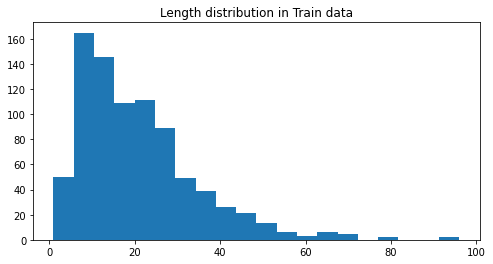

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посмотрим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [4]:
from torch import nn

class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()
  
        self.embeddings = nn.Embedding(
            num_embeddings=len(WORD.vocab),
            embedding_dim=emb_dim,
            # pad_idx=TEXT.vocab.stoi[WORD.pad_token]
        )
        self.dropout = nn.Dropout(dropout)
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=2,
            bidirectional=bidirectional,
            dropout=dropout
        )
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        '''
        sent: [sent len, batch size]
        embedded: [sent len, batch size, emb dim]
        output: [sent len, batch size, hid dim * n directions]
        '''
        # не забываем применить dropout к embedding
        # print(sent)
        embedded = self.embeddings(sent)
        embedded = self.dropout(embedded)
        # pack sequence
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())
        output, _ = self.rnn(embedded)

        prediction = self.tag(output)
    
        return prediction

In [5]:
# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [ ]:
# параметры модели
INPUT_DIM = 0
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 100
HID_DIM = 128
DROPOUT = 0
BIDIRECTIONAL = False

model = LSTMTagger(
    input_dim=INPUT_DIM,
    emb_dim=OUTPUT_DIM,
    hid_dim=HID_DIM,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL
).to(device)
        
model.apply(init_weights)

Подсчитаем количество обучаемых параметров нашей модели

In [6]:
def count_parameters(model):
    count = 0
    print('Parameter names:', end=' ')
    for name, params in model.named_parameters():
        print(name, end=', ')
        count += params.numel()
    print()
    return count

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

Parameter names: embeddings.weight, rnn.weight_ih_l0, rnn.weight_hh_l0, rnn.bias_ih_l0, rnn.bias_hh_l0, tag.weight, tag.bias, 
The model has 84,266 trainable parameters


Погнали обучать

In [ ]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [7]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        words = batch.words
        tags = batch.tags  # tags: [sent len, batch size]

        optimizer.zero_grad()
        output = model(words)  # output = [sent len, batch size, output dim]
        output = output.flatten(start_dim=0, end_dim=-2)  # output: [sent len * batch size, output dim]

        tags = tags.view(-1)  # tags: [sent len * batch size]
        
        loss = criterion(output, tags)
        loss.backward()
        # Gradient clipping(решение проблемы взрыва градента), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words = batch.words
            tags = batch.tags  # tags: [sent len, batch size]

            output = model(words)  # output: [sent len, batch size, output dim]
            output = output.flatten(start_dim=0, end_dim=-2)  # output: [sent len * batch size, output dim]
            tags = tags.view(-1)  # tags: [sent len * batch size]

            loss = criterion(output, tags)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

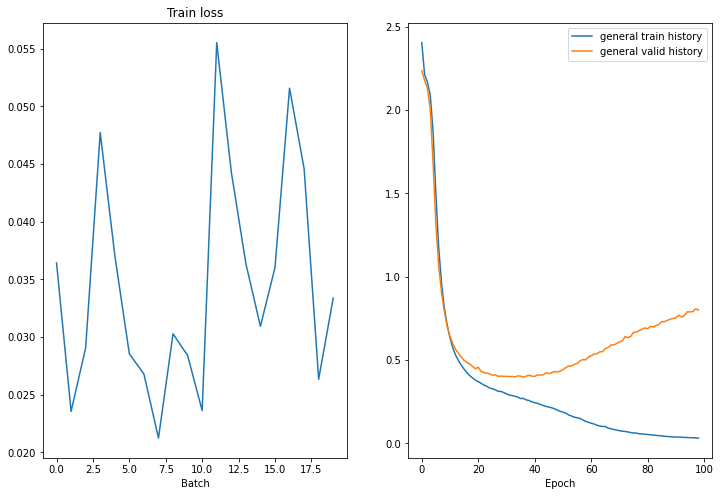

Epoch: 100 | Time: 0m 1s
	Train Loss: 0.034 | Train PPL:   1.035
	 Val. Loss: 0.811 |  Val. PPL:   2.250


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 100
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [8]:
def accuracy_model(model, iterator):
    model.eval()
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words = batch.words
            tags = batch.tags  # tags: [sent len, batch size]

            output = model(words)  # output: [sent len, batch size, output dim]
            _, predict_tags = torch.max(output, dim=-1)  # output: [sent len, batch size]
            predict_tags = predict_tags.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
            
    return round(true_pred / num_pred * 100, 3)

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 88.788 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [9]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


In [10]:
from torchtext.legacy.data import Field, BucketIterator, Example, Dataset
# import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

# кладем примеры в наш датасет
dataset = Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [30]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 45086
Unique tokens in target (en) vocabulary: 13
['<unk>', '2', 'wife', 'added', 'press', 'seven', 'distribution', 'knife', 'dry', 'somebody', 'weapons', 'shoulders', 'carl', 'believes', 'regional', 'tissue', 'christianity', 'adjustment', 'responsibilities', 'farther', 'pond', 'worthy', 'displacement', 'calif.', 'arnold', 'startling', 'milling', 'detroit', 'superiority', 'landscape', 'beloved', 'monstrous', 'averaged', 'lagoon', '800', 'hogan', 'sigh', 'competitors', 'liking', 'stereotype', 'chains', 'herbert', 'ramsey', 'wounds', 'complaints', 'glove', 'olgivanna', 'spends', 'advocating', 'concentrates', 'fingerprint', 'large-scale', 'premise', 'strife', '68', 'capacities', 'dispatched', 'grandmother', 'm.p.h.', 'ponies', 'self-determination', 'throats', '30th', 'barcus', 'coincided', 'divinity', 'formulae', 'incisive', 'make-up', 'overthrow', 'rationalism', 'skirts', 'toronto', "year-'round", 'allegedly', 'bicycle', 'chat', 'creed', 'divertin

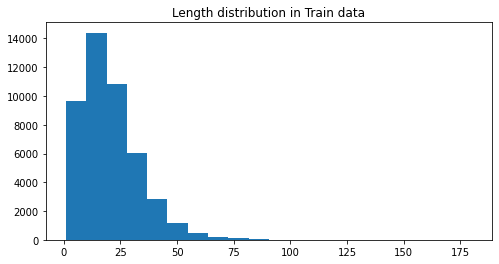

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [12]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

# посмотрим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[180, 23, 23]

Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [22]:
# параметры модели
INPUT_DIM = 0
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 200
HID_DIM = 256
DROPOUT = 0.8
BIDIRECTIONAL = True

In [31]:
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
model.apply(init_weights)
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
print(f'The model has {count_parameters(model):,} trainable parameters')

Parameter names: embeddings.weight, rnn.weight_ih_l0, rnn.weight_hh_l0, rnn.bias_ih_l0, rnn.bias_hh_l0, rnn.weight_ih_l0_reverse, rnn.weight_hh_l0_reverse, rnn.bias_ih_l0_reverse, rnn.bias_hh_l0_reverse, rnn.weight_ih_l1, rnn.weight_hh_l1, rnn.bias_ih_l1, rnn.bias_hh_l1, rnn.weight_ih_l1_reverse, rnn.weight_hh_l1_reverse, rnn.bias_ih_l1_reverse, rnn.bias_hh_l1_reverse, tag.weight, tag.bias, 
The model has 11,538,813 trainable parameters


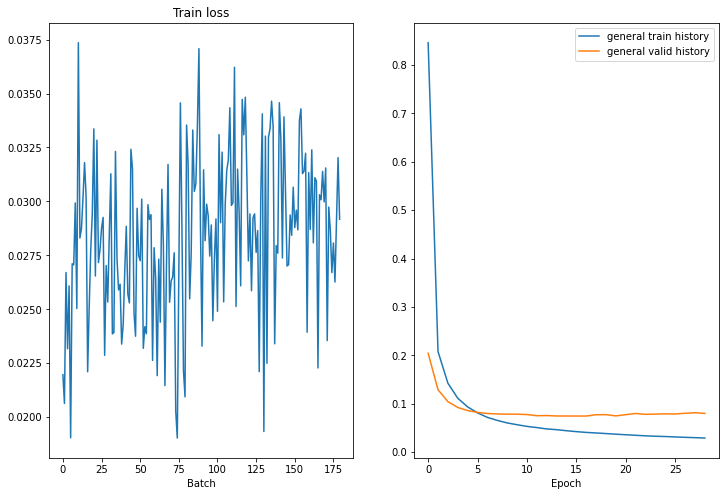

Epoch: 30 | Time: 0m 49s
	Train Loss: 0.028 | Train PPL:   1.029
	 Val. Loss: 0.081 |  Val. PPL:   1.084


In [32]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 30
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [33]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 98.049 %


In [ ]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


EMB_DIM|HID_DIM|DROPOUT|BIDIRECTIONAL|Accuracy
-|-|-|-|-
100|128|0|False|Val loss растёт, модель сразу переобучается
100|128|0.5|False|95.468 %
300|128|0.5|False|95.23 %
100|256|0.5|False|95.463 %
300|256|0.5|False|95.467 %
100|128|0.5|True|97.187 %
300|128|0.5|True|96.971 %
100|256|0.5|True|97.148 %
300|256|0.5|True|97.022 %
100|128|0.7|True|97.389 %
100|128|0.7|False|95.585 % (2 слоя)
100|128|0.7|True|97.443 % (2 слоя)
200|256|0.8|True|97.538 % (2 слоя)
200|256|0.8|True|98.049 % (2 слоя, словарь min_freq=1)

Пример решения нашей задачи:

In [34]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [35]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             PRT
gauge          VERB
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     ADJ
.              .


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

Модель|humor|whole corpus
-|-|-
HiddenMarkov|88.8 %|96.3 %
LstmTagger|88.788 %|98.049 %

Результаты обоих моделей имеют соспоставимое качество и на одной категории, и на всём корпусе. Однако, нейронная модель имеет больше возможностей для настройки и, как следствие, лучшего качества.